In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
data = pd.read_csv("bank-full.csv", sep = ";")

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Test, Train Split

Before performing any preprocessing, we split the data into training and test sets. The reason for this is that we will determine preprocessing parameters based only on the training data, and then apply the same transformations to the test data. This ensures more consistent results in real-world scenarios and prevents data leakage, which can occur if test data influences the training process.

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop("y", axis=1)  
y = data["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)


### Convert Into Numerical Dataset - Encoding

The classification algorithms we use require numerical data, so we convert the entire dataset, except for the class label, into numerical format.

In [5]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

# Data Conversion with Label Encoding Method for Ordinal Data
for col in ["education", "month"]:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])



There has been an update to pd.get_dummies() to return bool dtypes by default (rather than float or int).

You can get the behaviour of the first screenshot by setting pd.get_dummies(dtype=int).

In [6]:
onehot_encoder_columns = ["job", "marital", "default", "housing", "loan", "contact", "poutcome"]

X_train = pd.get_dummies(X_train, columns=onehot_encoder_columns, dtype=int)
X_test = pd.get_dummies(X_test, columns=onehot_encoder_columns, dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [7]:
# IQR yöntemi ile aykırı değerleri bulma fonksiyonu
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


In [8]:
# Winsorization (uç noktalarla değiştirme) fonksiyonu
def winsorize_outliers(df, column, lower_bound, upper_bound):
    
    # Aykırı değerleri alt ve üst sınırlarla değiştir
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [9]:
#Outliers için X_train setinde belirleyip uyguladığımız dönüşümleri, X_test üzerinde X_Train setinden elde ettiğimiz 
#verilere göre uyguluyoruz. Bu sayede test setiyle ilgili bilgi sızmasını engelleyerek modelin test seti hakkında gerçekten hiçbir bilgi birikimi olmadan 
#eğitilesini sağlamış oluruz
for col in X_train.columns:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(X_train, col)
    winsorize_outliers(X_train, col, lower_bound, upper_bound)
    winsorize_outliers(X_test, col, lower_bound, upper_bound)

In [10]:
def boxplot_function(df):
    column_size = len(df.columns)
    if (column_size % 4) == 0:
        height = column_size / 4
    elif (column_size % 4) != 0:
        height = (column_size / 4) + 1
        
    fig, axes = plt.subplots(int(height), 4, figsize=(20, 20))
    axes = axes.flatten()
    
   
    for i, column in enumerate(df.columns):
        sns.boxplot(df[column], ax=axes[i])  # Her sütunu ayrı bir eksende çizdir
        axes[i].set_title(column)
    
    plt.tight_layout()
    plt.show()

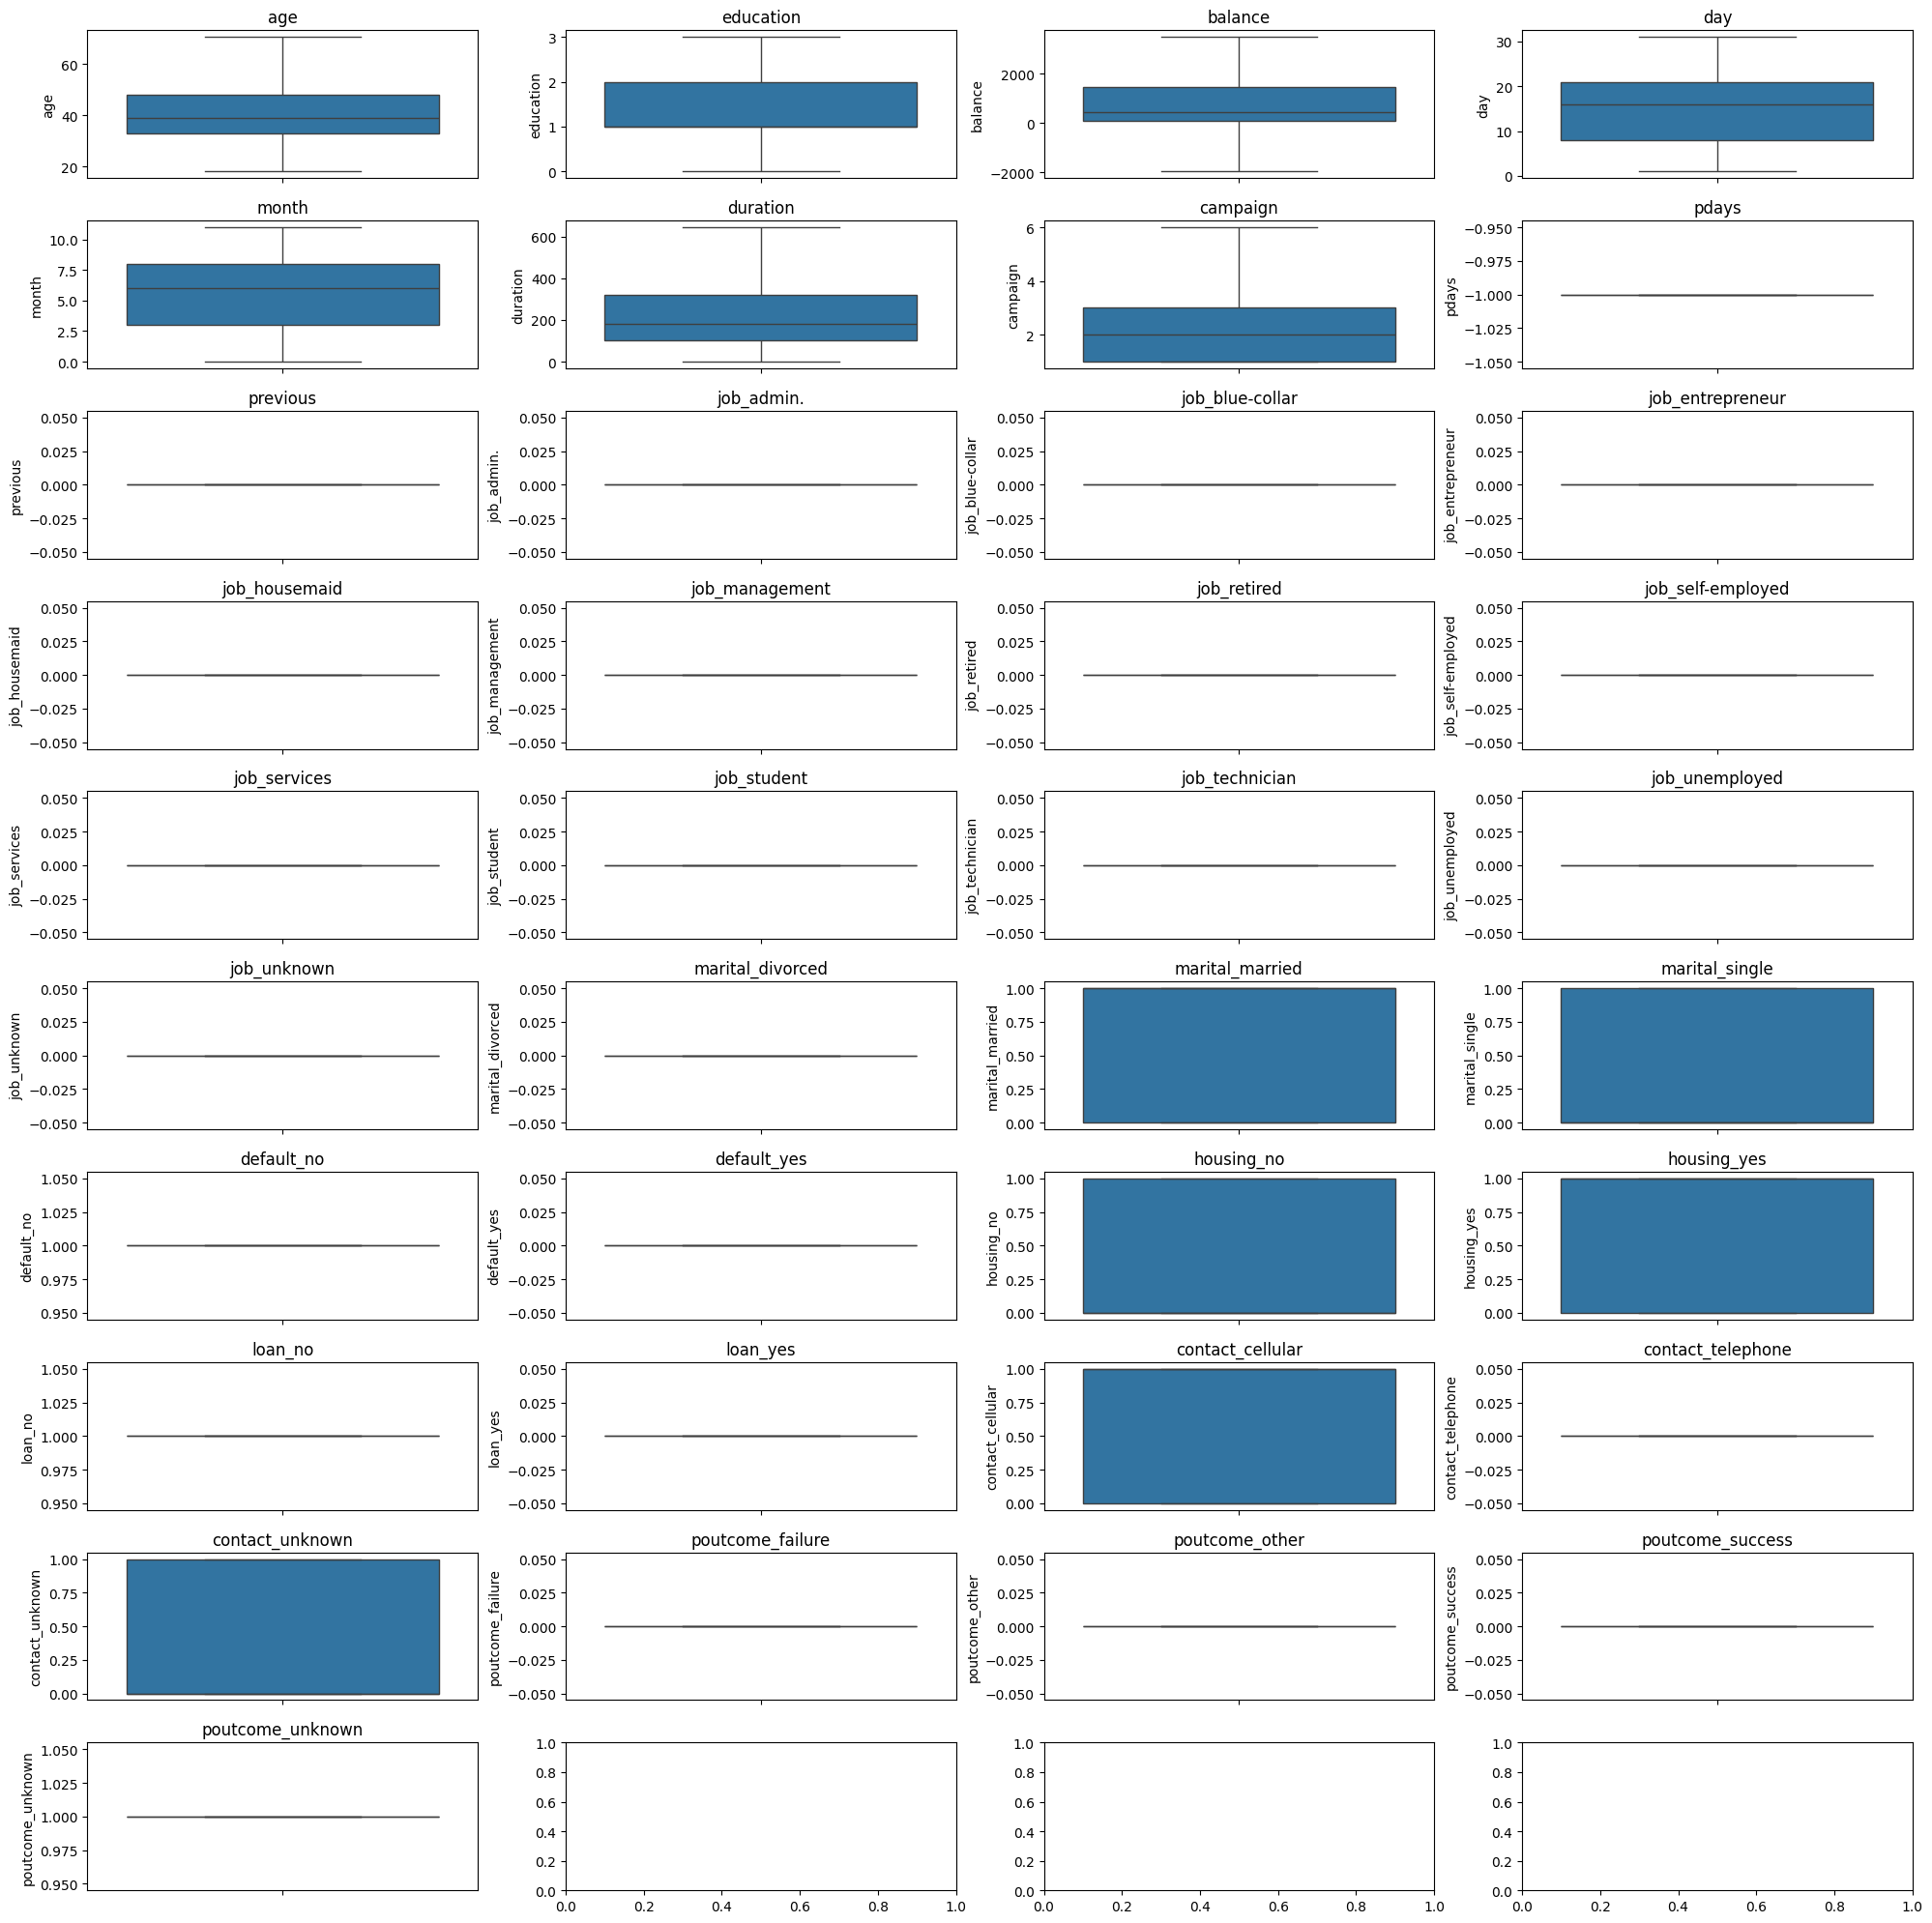

In [11]:
boxplot_function(X_train);

### Min-Max Scaling

<p>
    The dataset contained features with highly imbalanced ranges, which could negatively impact the performance of machine learning algorithms that are sensitive to scale variations. To address this, I applied Min-Max Scaling, a normalization technique that transforms the data by rescaling each feature to a specific range, typically between 0 and 1. This ensures that all features contribute equally during model training, preventing features with larger ranges from dominating the learning process and improving model convergence. </p>
<p>
    Next, I identified columns with high skewness and others with standard deviations significantly different from 1, which indicated that the data was not normally distributed. To address this, I applied the Yeo-Johnson transformation using the PowerTransformer. This technique is designed to stabilize variance and make the data more closely follow a normal distribution, which is beneficial for many machine learning algorithms that assume normality in the input data.
</p>

In [8]:
scaler = MinMaxScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_test_normalized = pd.DataFrame(scaler.transform(X_test))

In [9]:
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method = "yeo-johnson")
X_train_standard = pd.DataFrame(transformer.fit_transform(X_train_normalized))
X_test_standard = pd.DataFrame(transformer.transform(X_test_normalized))

### XGBoost Classification

I used XGBoost for the classification task because it is a fast and effective machine learning algorithm. XGBoost improves model performance through boosting, which combines multiple weak learners to create a strong one. It also helps prevent overfitting, making the model more reliable. By using XGBoost, I aimed to achieve better accuracy and handle the class imbalance in the dataset more effectively.

In [10]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [11]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(
    X_train_standard, 
    y_train_encoded
)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In this process, I used cross-validation to evaluate the performance of my XGBoost model. Cross-validation helps us understand how well the model will perform on new, unseen data by dividing the training dataset into multiple parts.

We split the training data into several subsets, train the model on some of them, and test it on the remaining subset. This is done multiple times to ensure each part is tested.

The results from each test are collected, showing how accurately the model predicts outcomes on different data portions.

Finally, we calculate the average accuracy score from all tests. This average gives us a more reliable indication of the model's overall performance, helping us ensure it generalizes well and doesn’t just memorize the training data.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

cv_scores = cross_val_score(xgb_model, X_train_standard, y_train_encoded, cv=5)
print(f'Cross Validation Scores: {cv_scores}')
print(f'Average Validation Score: {np.mean(cv_scores)}')

Cross Validation Scores: [0.90392591 0.90710534 0.91139066 0.90128577 0.90626296]
Average Validation Score: 0.9059941263128273


In [13]:
y_pred = xgb_model.predict(X_test_standard)

In [14]:
print("Classification Results:")
print(classification_report(y_test_encoded, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))


Classification Results:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8005
           1       0.61      0.50      0.55      1038

    accuracy                           0.91      9043
   macro avg       0.77      0.73      0.75      9043
weighted avg       0.90      0.91      0.90      9043

Confusion Matrix:
[[7673  332]
 [ 521  517]]


In this code, I used Grid Search to optimize the hyperparameters of my XGBoost model. The goal is to improve the model's performance, especially for the imbalanced classes in the dataset.

Parameter Grid: I defined a range of values for several hyperparameters, such as the number of trees, maximum depth of the trees, learning rate, and others. This grid includes various combinations that will be tested during the search.

Grid Search: I set up Grid Search with cross-validation to systematically evaluate each combination of hyperparameters. The scoring method is set to F1-score, which is particularly useful for imbalanced datasets, as it considers both precision and recall.

Fitting the Model: By calling fit, Grid Search trains the model using the training data for each combination of hyperparameters and evaluates their performance.

Best Hyperparameters: Finally, I retrieve and print the best hyperparameters found during the search, which should lead to improved model accuracy and better handling of the imbalanced classes.

Overall, this process allows me to fine-tune the model to achieve better predictive performance.

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
}

grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    scoring = "f1",  # Focus on F1-score for imbalanced datasets
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

grid_search.fit(X_train_standard, y_train_encoded)

print("Best Hyperparameters:", grid_search.best_params_)



Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [16]:
# Report
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_standard)

print("Classification Results of the Best Model:")
print(classification_report(y_test_encoded, y_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_best))


Classification Results of the Best Model:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8005
           1       0.63      0.50      0.56      1038

    accuracy                           0.91      9043
   macro avg       0.78      0.73      0.75      9043
weighted avg       0.90      0.91      0.90      9043

Confusion Matrix:
[[7703  302]
 [ 519  519]]


In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In this code, I built a neural network to classify the data, especially focusing on the imbalanced classes.

Model Structure: The model consists of several layers. The first layer has 64 neurons with ReLU activation, and I used dropout layers to reduce overfitting by randomly turning off some neurons during training.

Output Layer: The output layer has a single neuron with a sigmoid activation function for binary classification.

Training the Model: I compiled the model with the Adam optimizer and binary cross-entropy loss, then trained it using standardized data. I included early stopping to prevent overfitting, which stops training if the validation loss doesn't improve for a set number of epochs.

Evaluation: After training, I made predictions on the test data and printed the confusion matrix and classification report to assess the model’s performance.

I chose a neural network because its layered structure can capture complex patterns, making it a good choice for dealing with imbalanced classes.

In [18]:
model = Sequential()

model.add(Dense(64, input_dim = X_train_standard.shape[1], activation = "relu"))
model.add(Dropout(0.5))  # Overfitting'i azaltmak için Dropout kullanımı


model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

history = model.fit(X_train_standard, y_train_encoded, 
                    validation_data=(X_test_standard, y_test_encoded),
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping],
                    verbose=2)


y_pred = (model.predict(X_test_standard) > 0.5).astype("int32")

print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))


Epoch 1/100


C:\Users\betul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1131/1131 - 2s - 1ms/step - accuracy: 0.8793 - loss: 0.3187 - val_accuracy: 0.8975 - val_loss: 0.2455
Epoch 2/100
1131/1131 - 1s - 589us/step - accuracy: 0.8913 - loss: 0.2606 - val_accuracy: 0.8978 - val_loss: 0.2426
Epoch 3/100
1131/1131 - 1s - 605us/step - accuracy: 0.8926 - loss: 0.2506 - val_accuracy: 0.8979 - val_loss: 0.2405
Epoch 4/100
1131/1131 - 1s - 591us/step - accuracy: 0.8943 - loss: 0.2473 - val_accuracy: 0.8969 - val_loss: 0.2402
Epoch 5/100
1131/1131 - 1s - 598us/step - accuracy: 0.8952 - loss: 0.2439 - val_accuracy: 0.8983 - val_loss: 0.2384
Epoch 6/100
1131/1131 - 1s - 687us/step - accuracy: 0.8951 - loss: 0.2434 - val_accuracy: 0.8986 - val_loss: 0.2385
Epoch 7/100
1131/1131 - 1s - 794us/step - accuracy: 0.8971 - loss: 0.2414 - val_accuracy: 0.8997 - val_loss: 0.2376
Epoch 8/100
1131/1131 - 1s - 685us/step - accuracy: 0.8952 - loss: 0.2404 - val_accuracy: 0.9017 - val_loss: 0.2369
Epoch 9/100
1131/1131 - 1s - 924us/step - accuracy: 0.8965 - loss: 0.2399 - val_accura